# Close Price Prediction at Moderna Stock 

In [1]:
#import library
import warnings
warnings.filterwarnings('ignore')
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

## Data Extraction

In [2]:
#load dataset
df = pd.read_csv('vaccine stocks.csv')

In [3]:
#show head of dataset
df.head()

,Ticker,BioNTech,BioNTech.1,BioNTech.2,BioNTech.3,BioNTech.4,BioNTech.5,Moderna,Moderna.1,Moderna.2,...,Novavax.2,Novavax.3,Novavax.4,Novavax.5,Astrazeneca,Astrazeneca.1,Astrazeneca.2,Astrazeneca.3,Astrazeneca.4,Astrazeneca.5
0,Stock Info,High,Low,Open,Close,Volume,Adj Close,High,Low,Open,...,Open,Close,Volume,Adj Close,High,Low,Open,Close,Volume,Adj Close
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-10-10,16.698999404907227,13.010000228881836,16.5,14.239999771118164,2805800,14.239999771118164,14.40999984741211,13.869999885559082,14.130000114440918,...,4.460000038146973,4.480000019073486,216900,4.480000019073486,43.79999923706055,43.15999984741211,43.20000076293945,43.599998474121094,6218200.0,41.256011962890625
3,2019-10-11,15.34000015258789,13.5,15.34000015258789,13.819999694824219,1364300,13.819999694824219,14.699999809265137,13.989999771118164,14.239999771118164,...,4.539999961853027,4.559999942779541,360400,4.559999942779541,44.15999984741211,43.540000915527344,43.7400016784668,43.58000183105469,3842900.0,41.237091064453125
4,2019-10-14,13.90999984741211,12.524999618530273,13.829999923706055,12.75,899100,12.75,14.270000457763672,13.670000076293945,14.1899995803833,...,4.550000190734863,4.690000057220459,371400,4.690000057220459,44.290000915527344,43.81999969482422,43.9900016784668,43.84000015258789,2651700.0,41.48311233520508


In [4]:
#check total rows and columns
df.shape

(480, 49)

In [5]:
#check columns of dataset
df.columns

Index(['Ticker', 'BioNTech', 'BioNTech.1', 'BioNTech.2', 'BioNTech.3',
       'BioNTech.4', 'BioNTech.5', 'Moderna', 'Moderna.1', 'Moderna.2',
       'Moderna.3', 'Moderna.4', 'Moderna.5', 'Johnson & Johnson',
       'Johnson & Johnson.1', 'Johnson & Johnson.2', 'Johnson & Johnson.3',
       'Johnson & Johnson.4', 'Johnson & Johnson.5', 'Inovio Pharmaceuticals',
       'Inovio Pharmaceuticals.1', 'Inovio Pharmaceuticals.2',
       'Inovio Pharmaceuticals.3', 'Inovio Pharmaceuticals.4',
       'Inovio Pharmaceuticals.5', 'Sinovac', 'Sinovac.1', 'Sinovac.2',
       'Sinovac.3', 'Sinovac.4', 'Sinovac.5', 'Sinopharm', 'Sinopharm.1',
       'Sinopharm.2', 'Sinopharm.3', 'Sinopharm.4', 'Sinopharm.5', 'Novavax',
       'Novavax.1', 'Novavax.2', 'Novavax.3', 'Novavax.4', 'Novavax.5',
       'Astrazeneca', 'Astrazeneca.1', 'Astrazeneca.2', 'Astrazeneca.3',
       'Astrazeneca.4', 'Astrazeneca.5'],
      dtype='object')

## Moderna Company Stock

In [6]:
#drop attribute columns beside moderna attributes of dataset
df_moderna = df.drop(columns = ['BioNTech', 'BioNTech.1', 'BioNTech.2', 'BioNTech.3',
                                'BioNTech.4', 'BioNTech.5', 'Johnson & Johnson',
                                'Johnson & Johnson.1', 'Johnson & Johnson.2', 'Johnson & Johnson.3',
                                'Johnson & Johnson.4', 'Johnson & Johnson.5', 'Inovio Pharmaceuticals',
                                'Inovio Pharmaceuticals.1', 'Inovio Pharmaceuticals.2',
                                'Inovio Pharmaceuticals.3', 'Inovio Pharmaceuticals.4',
                                'Inovio Pharmaceuticals.5', 'Sinovac', 'Sinovac.1', 'Sinovac.2',
                                'Sinovac.3', 'Sinovac.4', 'Sinovac.5', 'Sinopharm', 'Sinopharm.1',
                                'Sinopharm.2', 'Sinopharm.3', 'Sinopharm.4', 'Sinopharm.5', 'Novavax',
                                'Novavax.1', 'Novavax.2', 'Novavax.3', 'Novavax.4', 'Novavax.5',
                                'Astrazeneca', 'Astrazeneca.1', 'Astrazeneca.2', 'Astrazeneca.3',
                                'Astrazeneca.4', 'Astrazeneca.5'])

#rename attribute of moderna dataset
df_moderna = df_moderna.rename(columns = {'Ticker' : 'Date', 'Moderna' : 'High', 'Moderna.1' : 'Low', 'Moderna.2' : 'Open', 
                                          'Moderna.3' : 'Close', 'Moderna.4' : 'Volume'})
df_moderna = df_moderna.drop(columns = ['Moderna.5'])
df_moderna = df_moderna.drop(index = [0, 1])
df_moderna.head()

,Date,High,Low,Open,Close,Volume
2,2019-10-10,14.40999984741211,13.869999885559082,14.130000114440918,14.15999984741211,1343300
3,2019-10-11,14.699999809265137,13.989999771118164,14.239999771118164,14.055000305175781,934900
4,2019-10-14,14.270000457763672,13.670000076293945,14.1899995803833,13.930000305175781,954300
5,2019-10-15,14.449999809265137,13.529999732971191,13.930000305175781,14.329999923706055,1153500
6,2019-10-16,14.319999694824219,14.020000457763672,14.270000457763672,14.149999618530273,914100


## Exploratory Data Analysis (EDA)

In [7]:
#check total rows and columns 
df_moderna.shape

(478, 6)

In [8]:
#check missing value
df_moderna.isnull().sum()

Date      0
High      0
Low       0
Open      0
Close     0
Volume    0
dtype: int64

In [9]:
#check type of dataset
df_moderna.dtypes

Date      object
High      object
Low       object
Open      object
Close     object
Volume    object
dtype: object

In [10]:
#transform string attribute from high, low, open, close & volume to float
for i in df_moderna[['High', 'Low', 'Open', 'Close', 'Volume']]:
    df_moderna[i] = [float(str(i).replace('', '')) for i in df_moderna[i]]
    
df_moderna.dtypes

Date       object
High      float64
Low       float64
Open      float64
Close     float64
Volume    float64
dtype: object

In [11]:
#describe dataset
df_moderna.describe()

,High,Low,Open,Close,Volume
count,478.000000,478.000000,478.000000,478.000000,4.780000e+02
mean,112.400511,104.757408,108.401628,108.941632,1.467463e+07
std,99.154501,91.851526,94.989140,95.999062,1.588032e+07
min,14.270000,13.530000,13.930000,13.930000,4.889000e+05
25%,32.949999,29.540000,32.090000,31.650000,5.487050e+06
50%,73.910000,70.160004,72.035000,71.575001,1.068410e+07
75%,160.707500,148.384995,154.108749,156.447498,1.695458e+07
max,497.489990,454.000000,485.500000,484.470001,1.251304e+08


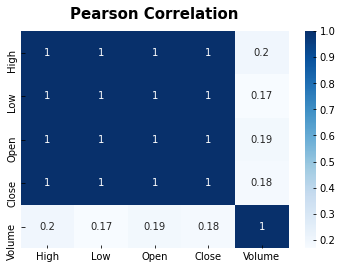

In [12]:
#visualize correlation of each numerical variable using pearson correlation
sns.heatmap(df_moderna.corr(), annot = True, cmap = 'Blues')
plt.title('Pearson Correlation', fontsize = 15, pad = 12, fontweight = 'bold')
plt.show()

In [13]:
#indexing date column on moderna stock
df_moderna['Date'] = pd.to_datetime(df_moderna['Date'], format = '%Y-%m-%d')
df_moderna = df_moderna.set_index('Date')
df_moderna.index

DatetimeIndex(['2019-10-10', '2019-10-11', '2019-10-14', '2019-10-15',
               '2019-10-16', '2019-10-17', '2019-10-18', '2019-10-21',
               '2019-10-22', '2019-10-23',
               ...
               '2021-08-19', '2021-08-20', '2021-08-23', '2021-08-24',
               '2021-08-25', '2021-08-26', '2021-08-27', '2021-08-30',
               '2021-08-31', '2021-09-01'],
              dtype='datetime64[ns]', name='Date', length=478, freq=None)

In [14]:
#feature scaling
scaler = MinMaxScaler()
scaler.fit_transform(df_moderna)

array([[2.89721851e-04, 7.71903086e-04, 4.24114785e-04, 4.88799128e-04,
        6.85485974e-03],
       [8.89862507e-04, 1.04433909e-03, 6.57377412e-04, 2.65652229e-04,
        3.57826246e-03],
       [0.00000000e+00, 3.17843084e-04, 5.51348210e-04, 0.00000000e+00,
        3.73390885e-03],
       ...,
       [7.75568097e-01, 7.92948414e-01, 7.52952902e-01, 7.58192718e-01,
        1.20673291e-01],
       [7.66545259e-01, 8.10429768e-01, 7.67606089e-01, 7.70944025e-01,
        8.37088771e-02],
       [7.87860640e-01, 8.21100216e-01, 7.82295323e-01, 7.99103161e-01,
        8.92832644e-02]])

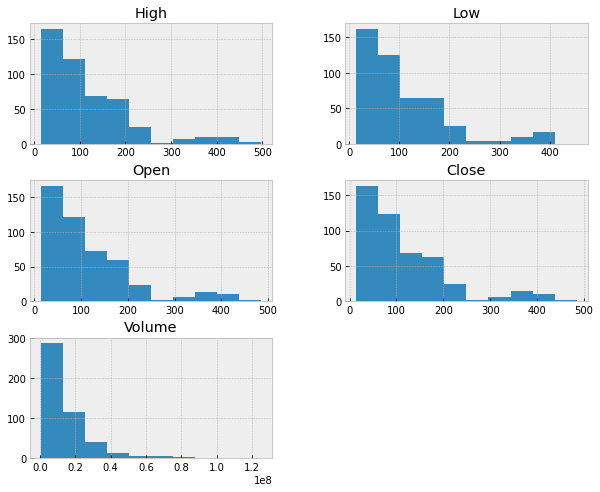

In [15]:
#visualize all distribution of dataset
df_moderna.hist(figsize = (10,8))
plt.show()

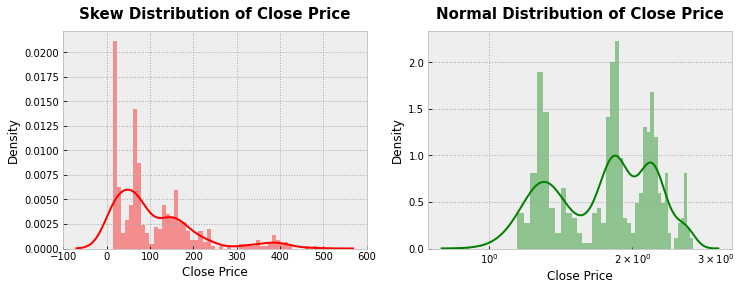

In [16]:
#transform skew distribution to normal distribution of close price
f = plt.figure(figsize = (12,4))

ax = f.add_subplot(121)
sns.distplot(df_moderna['Close'], bins = 50, color = 'r', ax = ax)
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
ax.set_title('Skew Distribution of Close Price', fontsize = 15, pad = 12, fontweight = 'bold')
ax.set_xlabel('Close Price', fontsize = 12)
ax.set_ylabel('Density', fontsize = 12)

ax = f.add_subplot(122)
sns.distplot(np.log10(df_moderna['Close']), bins = 40, color = 'g', ax = ax)
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
ax.set_title('Normal Distribution of Close Price', fontsize = 15, pad = 12, fontweight = 'bold')
ax.set_xlabel('Close Price', fontsize = 12)
ax.set_ylabel('Density', fontsize = 12)
ax.set_xscale('log')

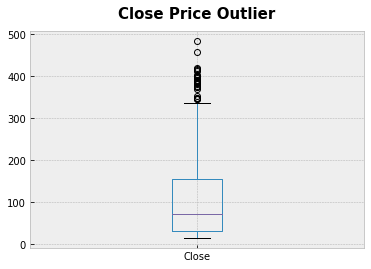

Maximum of Close Price : 484.4700012207031
Median of Close Price : 71.57500076293945
Minimum of Close Price : 13.930000305175781


In [17]:
#check outlier
df_moderna.boxplot(column = 'Close')
plt.title('Close Price Outlier', fontsize = 15, pad = 12, fontweight = 'bold')
plt.show()

print('Maximum of Close Price :', df_moderna['Close'].max())
print('Median of Close Price :', df_moderna['Close'].median())
print('Minimum of Close Price :', df_moderna['Close'].min())

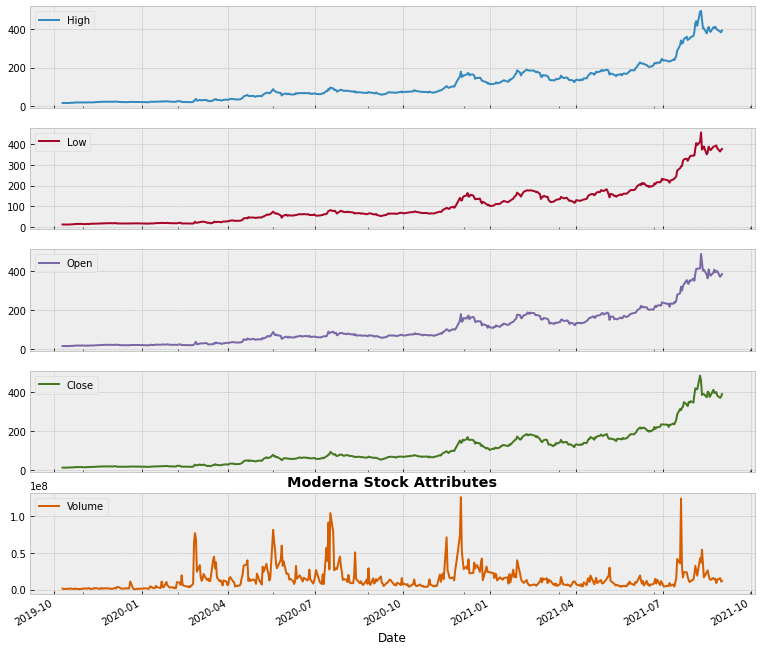

In [18]:
#visualize of each attribute columns
df_moderna['2019':'2021'].plot(subplots = True, figsize = (13,12))
plt.title('Moderna Stock Attributes', fontweight = 'bold')
plt.show()

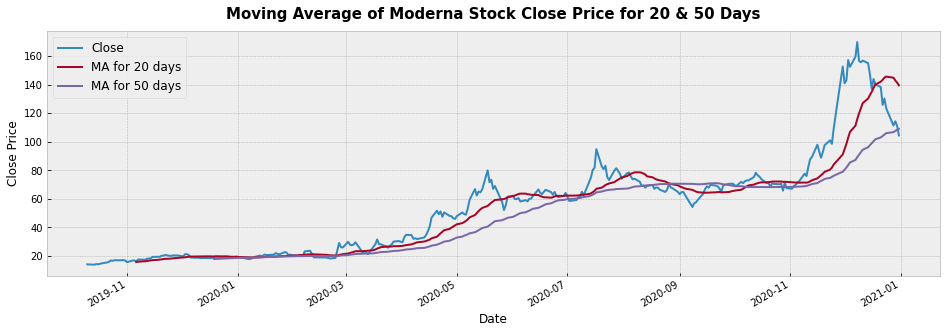

In [19]:
#check moving average
df_moderna['MA for 20 days'] = df_moderna['Close'].rolling(20).mean()
df_moderna['MA for 50 days'] = df_moderna['Close'].rolling(50).mean()

#visualize moving average
df_moderna.truncate(before = '2019-01-01', after = '2021-01-01')[['Close','MA for 20 days','MA for 50 days']].plot(
    subplots = False, figsize = (16,5))
plt.title('Moving Average of Moderna Stock Close Price for 20 & 50 Days', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price', fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

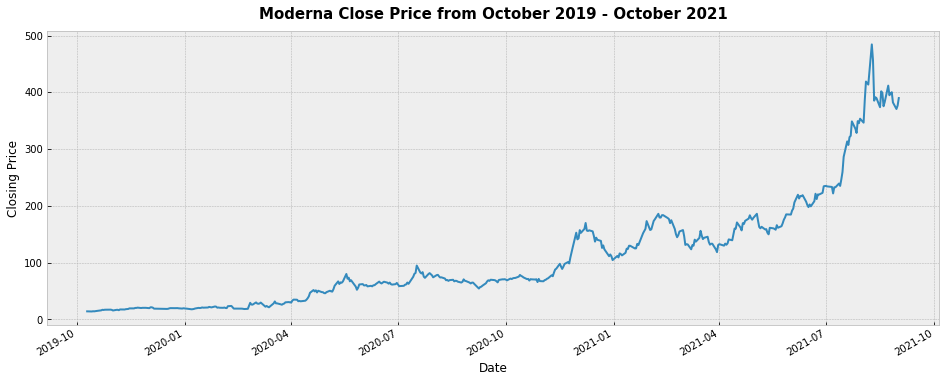

In [20]:
#visualize moderna stock close price
plt.figure(figsize = (16,6))
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Closing Price', fontsize = 12)
df_moderna['Close'].plot()
plt.title('Moderna Close Price from October 2019 - October 2021', fontsize = 15, pad = 12, fontweight = 'bold')
plt.show()

## Autoregressive Integrated Moving Average (ARIMA) 

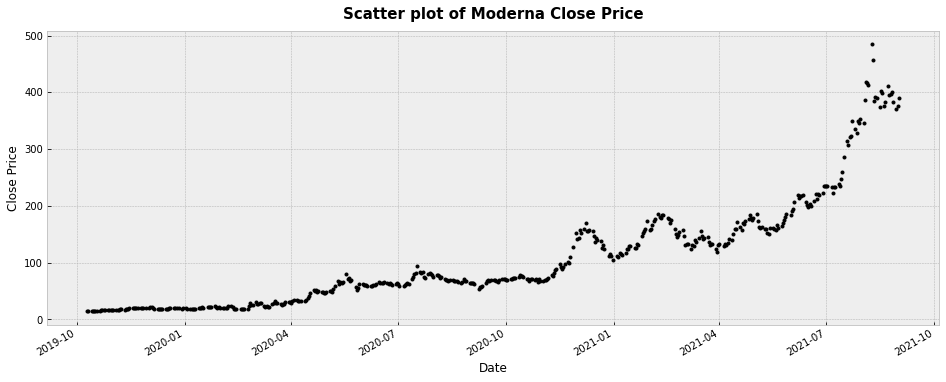

In [21]:
#visualize scatter plot of close price
df_close = df_moderna['Close']
df_close.plot(style = 'k.', figsize = (16,6))
plt.title('Scatter plot of Moderna Close Price', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price', fontsize = 12)
plt.show()

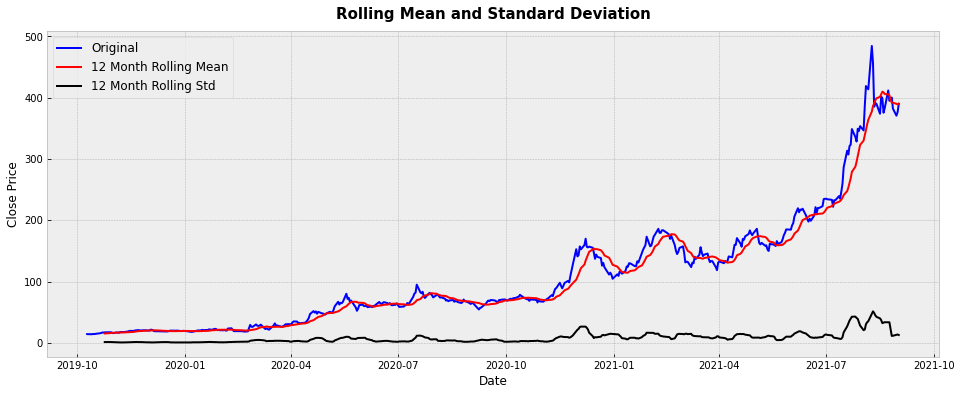

Results of dickey fuller test :
Test Statistics                  0.803946
p-value                          0.991700
No. of lags used                15.000000
Number of observations used    462.000000
critical value (1%)             -3.444584
critical value (5%)             -2.867816
critical value (10%)            -2.570113
dtype: float64


In [22]:
#check stationarity
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = '12 Month Rolling Mean')
    plt.plot(rolstd, color = 'black', label = '12 Month Rolling Std')
    plt.xlabel('Date', fontsize = 12)
    plt.ylabel('Close Price', fontsize = 12)
    plt.legend(loc = 'best', fontsize = 12)
    plt.title('Rolling Mean and Standard Deviation', fontsize = 15, pad = 12, fontweight = 'bold')
    plt.show(block = False)
    
    print('Results of dickey fuller test :')
    adft = adfuller(timeseries, autolag = 'AIC')
    output = pd.Series(adft[0:4], index = ['Test Statistics','p-value','No. of lags used','Number of observations used'])
    
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

#visualize rolling mean and standard deviation
plt.figure(figsize = (16,6))
test_stationarity(df_close)

<Figure size 1152x432 with 0 Axes>

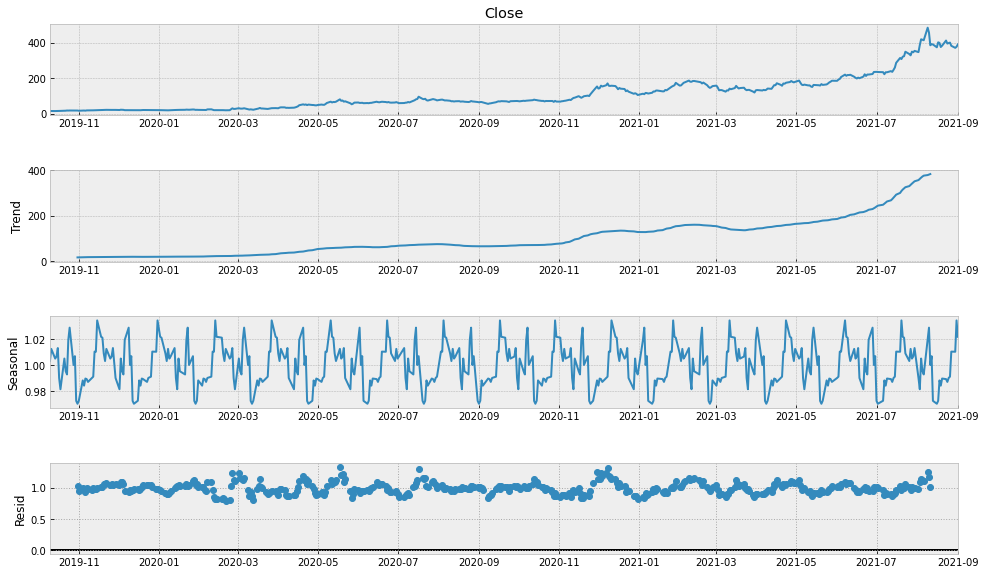

In [23]:
#visualize seasonal decomposition of close price
result = seasonal_decompose(df_close, model = 'multiplicative', freq = 30)
fig = plt.figure(figsize = (16,6))  
fig = result.plot()  
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
fig.set_size_inches(16, 9)
fig.show()

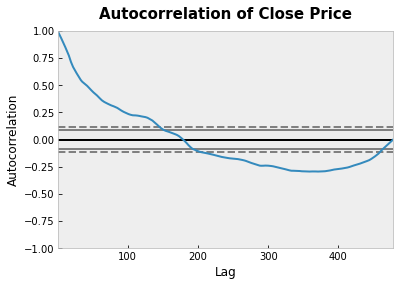

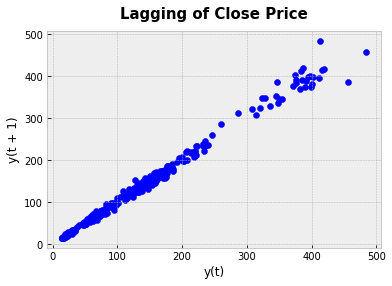

In [24]:
#visualize autocorrelation of close price
pd.plotting.autocorrelation_plot(df_moderna['Close'])
plt.title('Autocorrelation of Close Price', fontsize = 15, pad = 12, fontweight = 'bold')
plt.show()

#visualize lagging of close price
pd.plotting.lag_plot(df_moderna['Close'])
plt.title('Lagging of Close Price', fontsize = 15, pad = 12, fontweight = 'bold')
plt.show()

No handles with labels found to put in legend.


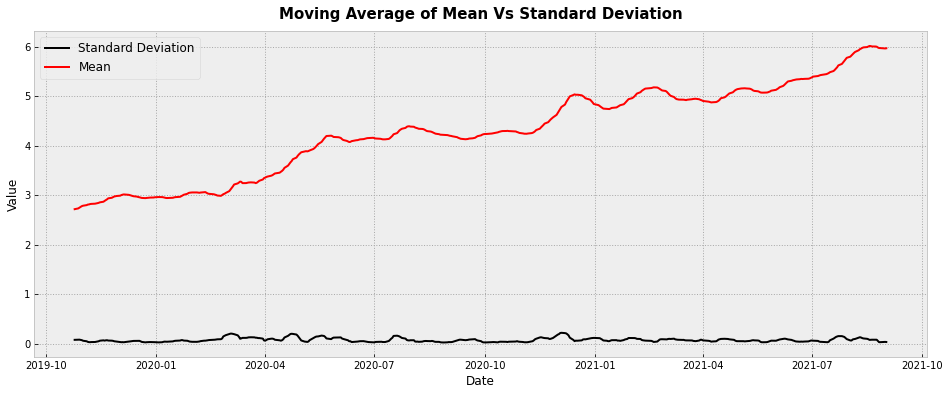

In [25]:
#visualize moving average based on standard deviation & mean
plt.figure(figsize = (16,6))  
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc = 'best')
plt.title('Moving Average of Mean Vs Standard Deviation', fontsize = 15, pad = 12, fontweight = 'bold')
plt.plot(std_dev, color = 'black', label = 'Standard Deviation')
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
plt.plot(moving_avg, color = 'red', label = 'Mean')
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Value', fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

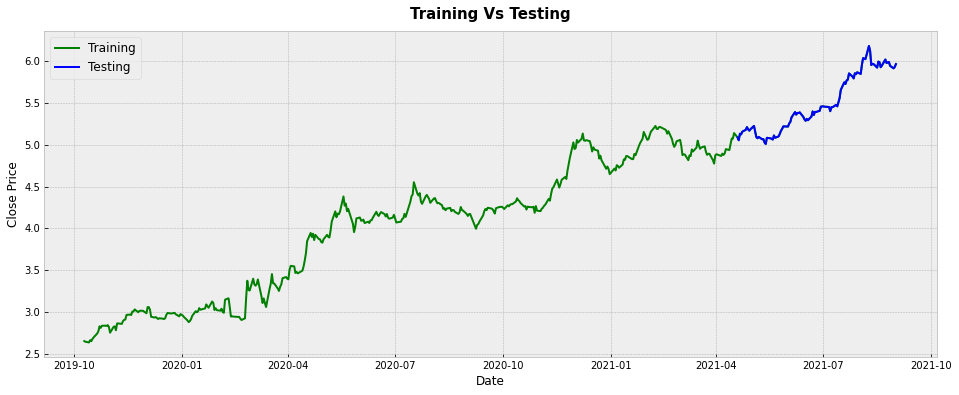

In [26]:
#visualize of training and testing set
train_data, test_data = df_log[3:int(len(df_log) * 0.8)], df_log[int(len(df_log) * 0.8):]
plt.figure(figsize = (16,6))
plt.grid(True)
plt.title('Training Vs Testing', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price', fontsize = 12)
plt.plot(df_log, 'green', label = 'Training')
plt.plot(test_data, 'blue', label = 'Testing')
plt.legend(fontsize = 12)
plt.show()

In [27]:
#build auto arima model for discover the optimal order in arima model
model_autoARIMA = auto_arima(train_data, trace = True, suppress_warnings = True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1100.160, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1098.983, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1097.600, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1097.690, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1095.883, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1095.271, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1095.472, Time=0.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1100.877, Time=0.45 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1094.846, Time=0.53 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-1094.382, Time=0.74 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1097.743, Time=0.72 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1101.068, Time=0.66 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1094.271, Time=0.59 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-1099.173, Time=0.87 sec
 ARIMA(1,1,4)(0,0,0

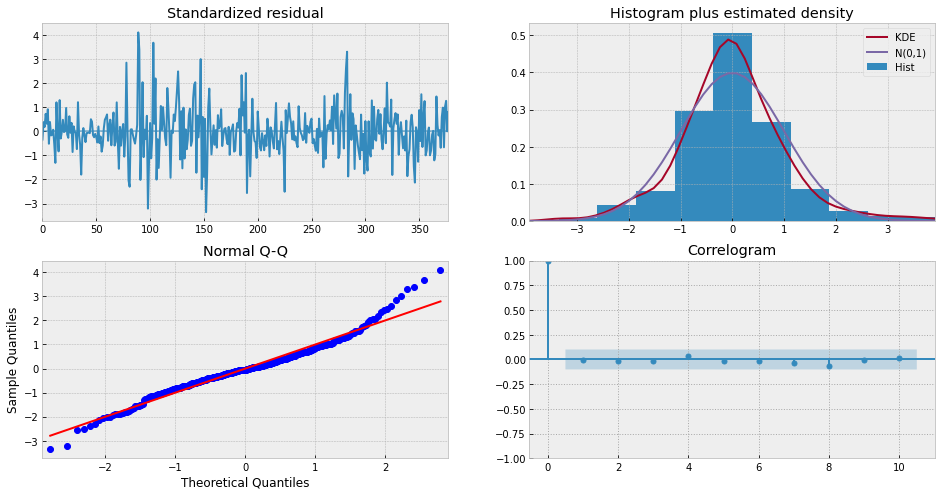

In [28]:
#visualize auto arima model
model_autoARIMA.plot_diagnostics(figsize = (16,8))
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
plt.show()

In [29]:
#build model
model = ARIMA(train_data, order = (2, 1, 3))  
fitted = model.fit(disp = 0)  
print(fitted.summary())

c:\users\bayu\opencv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\bayu\opencv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  378
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 557.546
Method:                       css-mle   S.D. of innovations              0.055
Date:                Sun, 29 May 2022   AIC                          -1101.093
Time:                        21:35:02   BIC                          -1073.549
Sample:                             1   HQIC                         -1090.161
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0066      0.003      2.162      0.031       0.001       0.013
ar.L1.D.Close    -0.1156      0.045     -2.557      0.011      -0.204      -0.027
ar.L2.D.Close    -0.9334      0.062    -

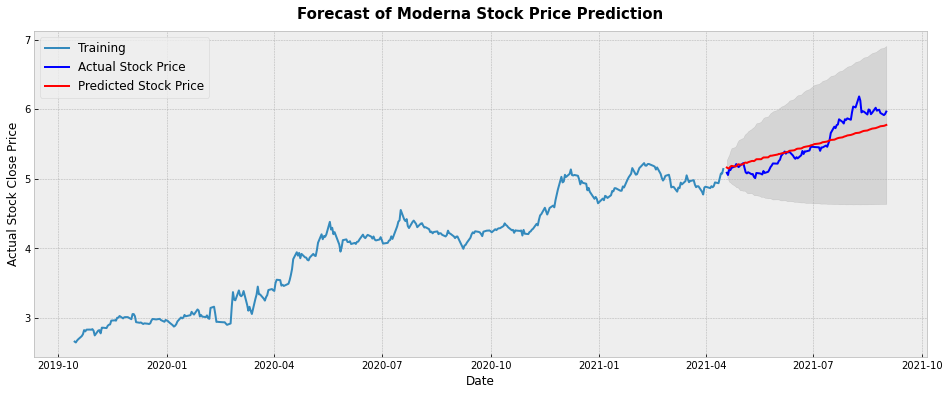

In [30]:
#visualize prediction using forecast of 96 hours to the future
fc, se, conf = fitted.forecast(96, alpha = 0.05) 
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:, 0], index = test_data.index)
upper_series = pd.Series(conf[:, 1], index = test_data.index)

plt.figure(figsize = (16,6))
plt.plot(train_data, label = 'Training')
plt.plot(test_data, color = 'blue', label = 'Actual Stock Price')
plt.plot(fc_series, color = 'red',label = 'Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = .10)
plt.title('Forecast of Moderna Stock Price Prediction', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Actual Stock Close Price', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [31]:
#check performance
mse = metrics.mean_squared_error(test_data, fc)
print('Mean Squared Error : '+str(mse))
mae = metrics.mean_absolute_error(test_data, fc)
print('Mean Absolute Error : '+str(mae))
rmse = math.sqrt(metrics.mean_squared_error(test_data, fc))
print('Root Mean Squared Error : '+str(rmse))
mape = np.mean(np.abs(fc - test_data) / np.abs(test_data))
print('Mean Absolute Percentage Error : '+str(mape))

Mean Squared Error : 0.03482651421593395
Mean Absolute Error : 0.15164927279643126
Root Mean Squared Error : 0.1866186330888048
Mean Absolute Percentage Error : 0.027007245663600438


## Linear Regression 

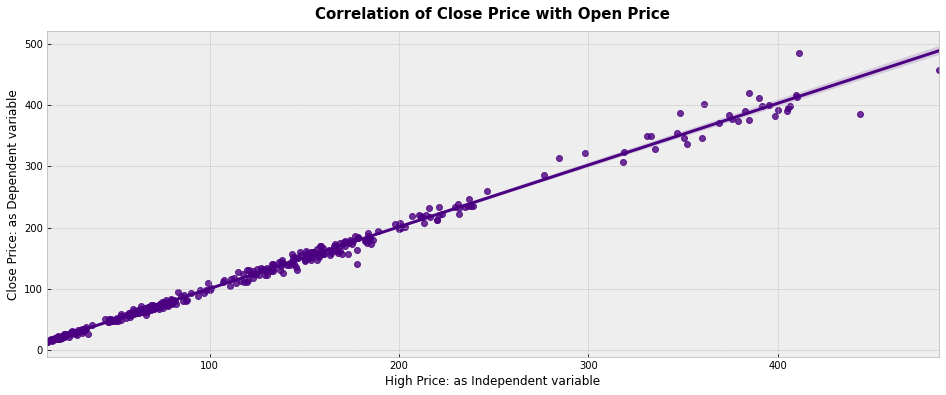

In [32]:
#visualize correlation of close price with open price
plt.figure(figsize = (16,6))
sns.regplot(data = df_moderna, x = 'Open', y = 'Close', color = 'indigo')
plt.title('Correlation of Close Price with Open Price', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('High Price: as Independent variable', fontsize = 12)
plt.ylabel('Close Price: as Dependent variable', fontsize = 12)
plt.show()

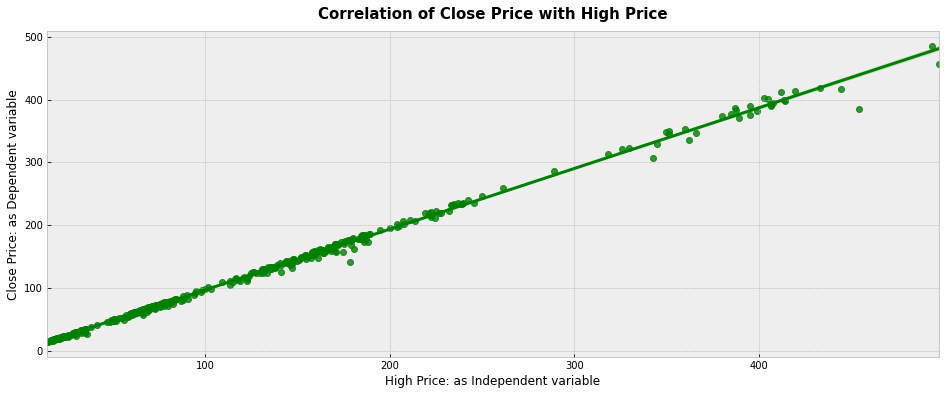

In [33]:
#visualize correlation of close price with high price
plt.figure(figsize = (16,6))
sns.regplot(data = df_moderna, x = 'High', y = 'Close', color = 'green')
plt.title('Correlation of Close Price with High Price', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('High Price: as Independent variable', fontsize = 12)
plt.ylabel('Close Price: as Dependent variable', fontsize = 12)
plt.show()

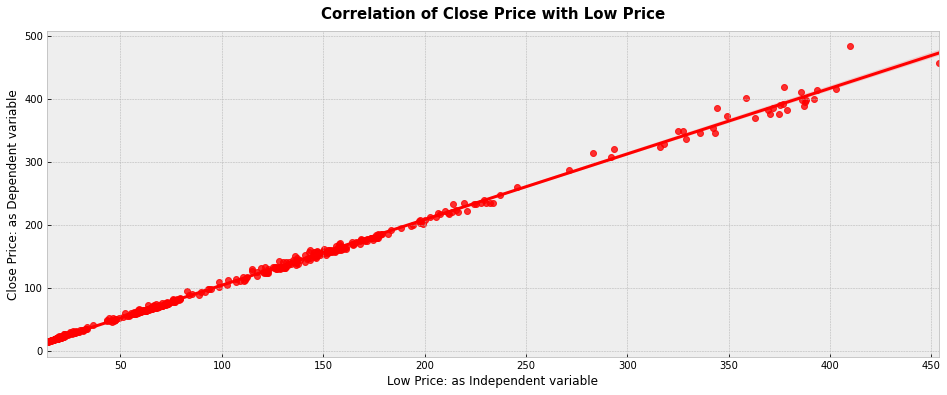

In [34]:
#visualize correlation of close price with low price
plt.figure(figsize = (16,6))
sns.regplot(data = df_moderna, x = 'Low', y = 'Close', color = 'red')
plt.title('Correlation of Close Price with Low Price', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('Low Price: as Independent variable', fontsize = 12)
plt.ylabel('Close Price: as Dependent variable', fontsize = 12)
plt.show()

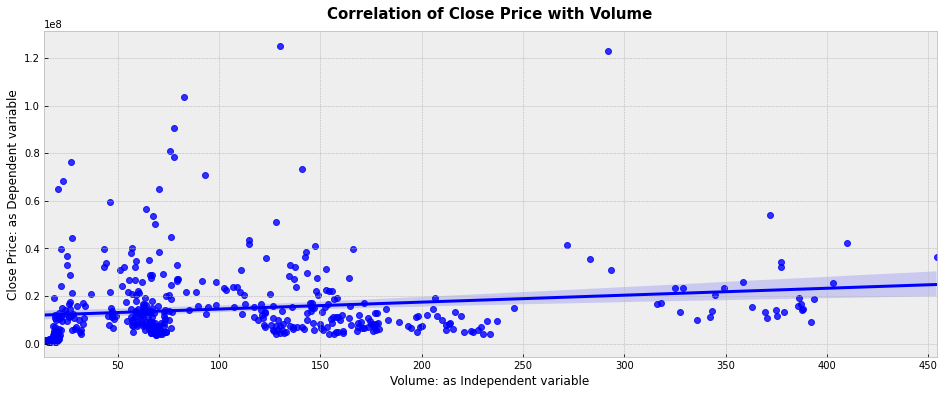

In [35]:
#visualize correlation of close price with volume
plt.figure(figsize = (16,6))
sns.regplot(data = df_moderna, x = 'Low', y = 'Volume', color = 'blue')
plt.title('Correlation of Close Price with Volume', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('Volume: as Independent variable', fontsize = 12)
plt.ylabel('Close Price: as Dependent variable', fontsize = 12)
plt.show()

In [36]:
#split data
X = df_moderna[['High', 'Low', 'Open', 'Volume']]
y = df_moderna['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(334, 4)
(334,)
(144, 4)
(144,)


In [37]:
#build linear regression model
lr = LinearRegression()
%time lr.fit(X_train, y_train)
print('Training Accuracy Score : {}'.format(lr.score(X_train, y_train)))
print('Testing Accuracy Score : {}'.format(lr.score(X_test, y_test)))

Wall time: 3 ms
Training Accuracy Score : 0.999200027197136
Testing Accuracy Score : 0.9993940962279969


In [38]:
#prediction 
y_pred = lr.predict(X_test)
print(y_pred)

[ 16.84647039  32.50565814  63.19387309  68.39668391 150.21148625
  50.17183247  48.42032928 144.39570249  25.16381908  17.49564447
 383.25787089  29.94017998  52.29397791 160.50597241  48.95171401
  63.66201111  21.03631958  25.42893463 109.42798567 130.36059521
  65.22838889  28.04983744 198.01280741  21.11061021 223.5730481
  67.50979987 227.62709148  80.6379913  166.27957959 153.84699263
 132.51716591  17.11740784 185.22781115 173.25580715 131.69259923
  50.03137211 119.75985785  68.40310322 179.92964624  69.14788147
  16.46106706  20.3646062  339.78804666  70.0649115   48.78157333
  14.56312336 177.05688089  66.98760978 229.10717433  70.95583998
 162.71776011 150.01114592 123.17556425  47.88072679  66.977286
  24.48954323 387.04192812 130.40814859 132.82220912 111.31269001
  57.73802311  69.19691522 155.66026233 160.18103497 393.13167058
  83.0496041   67.48560114  21.56436202 325.86492422 106.82766221
 156.87697822  19.55896089 239.16317582  55.92906013  73.13990732
  62.0451561 

In [39]:
#check MAE, MSE, RMSE & R2 score
mae = metrics.mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error : {}'.format(mae * 0.1))
mse = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error : {}'.format(mse * 0.01))
rmse = math.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error : {}'.format(rmse * 0.1))
r2_score = metrics.r2_score(y_test, y_pred).round(2)
print('R2 Score : {}'.format(r2_score))

Mean Absolute Error : 0.13254311854534184
Mean Squared Error : 0.052806460388288096
Root Mean Squared Error : 0.22979656304716156
R2 Score : 1.0


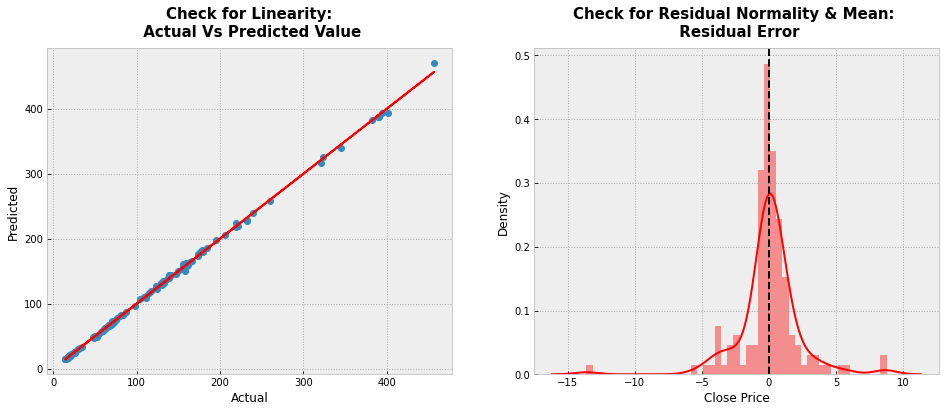

In [40]:
f = plt.figure(figsize = (16,6))

#check for linearity
ax = f.add_subplot(121)
plt.plot(y_test, y_pred, 'o')
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, color = 'r')
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
ax.set_title('Check for Linearity:\n Actual Vs Predicted Value', fontsize = 15, pad = 12, fontweight = 'bold')
ax.set_xlabel('Actual', fontsize = 12)
ax.set_ylabel('Predicted', fontsize = 12)

#check for residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred), ax = ax, color = 'r')
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
ax.axvline((y_test - y_pred).mean(), color = 'k', linestyle = '--')
ax.set_title('Check for Residual Normality & Mean: \n Residual Error', fontsize = 15, pad = 12, fontweight = 'bold')
ax.set_xlabel('Close Price', fontsize = 12)
ax.set_ylabel('Density', fontsize = 12)
plt.show()

In [41]:
#prediction of linear regression for forecast 60 days ahead
num = 60
X_Predict = X[-num:]
Forecast = lr.predict(X_Predict)
print(Forecast)

[219.87918958 214.02801659 217.85568052 201.45607716 203.90794122
 198.07628218 201.68849226 198.97161923 208.75839066 220.13490807
 212.38730453 219.76071472 221.89230455 219.08850657 233.98479395
 240.11666477 230.04867694 234.56199496 230.65257987 223.38456465
 229.10717433 227.62709148 239.16317582 235.77580915 247.87675611
 257.90599966 282.61327892 310.79916346 317.00218615 317.13670924
 325.86492422 341.75764025 342.11002438 329.78666199 343.59964542
 339.78804666 354.19907556 351.46756854 376.90508153 417.98595027
 432.58155335 404.62592619 477.23712083 470.35622076 394.44894875
 387.15000598 392.01466343 355.5589965  393.10199519 396.16045852
 385.49341073 381.28897323 404.70709344 393.13167058 407.12871506
 400.82017948 383.25787089 380.73596168 379.18129157 387.04192812]


In [42]:
#check last date for forecasting
date = np.array(df_moderna.index) 
last_date = date[len(date) - 1]
print(last_date)

2021-09-01T00:00:00.000000000


In [43]:
#create timeseries from the last date
time = pd.date_range('2021-09-01', periods = num, freq = 'd')
time

DatetimeIndex(['2021-09-01', '2021-09-02', '2021-09-03', '2021-09-04',
               '2021-09-05', '2021-09-06', '2021-09-07', '2021-09-08',
               '2021-09-09', '2021-09-10', '2021-09-11', '2021-09-12',
               '2021-09-13', '2021-09-14', '2021-09-15', '2021-09-16',
               '2021-09-17', '2021-09-18', '2021-09-19', '2021-09-20',
               '2021-09-21', '2021-09-22', '2021-09-23', '2021-09-24',
               '2021-09-25', '2021-09-26', '2021-09-27', '2021-09-28',
               '2021-09-29', '2021-09-30', '2021-10-01', '2021-10-02',
               '2021-10-03', '2021-10-04', '2021-10-05', '2021-10-06',
               '2021-10-07', '2021-10-08', '2021-10-09', '2021-10-10',
               '2021-10-11', '2021-10-12', '2021-10-13', '2021-10-14',
               '2021-10-15', '2021-10-16', '2021-10-17', '2021-10-18',
               '2021-10-19', '2021-10-20', '2021-10-21', '2021-10-22',
               '2021-10-23', '2021-10-24', '2021-10-25', '2021-10-26',
      

In [44]:
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']
df_predict.head()

,Forecast
2021-09-01,219.879190
2021-09-02,214.028017
2021-09-03,217.855681
2021-09-04,201.456077
2021-09-05,203.907941


In [45]:
#joining dataframe moderna & prediction result
df_result = pd.concat([df_moderna, df_predict], axis = 1)
df_result.tail(num)

,High,Low,Open,Close,Volume,MA for 20 days,MA for 50 days,Forecast
2021-09-01,394.980011,375.200012,382.837006,389.940002,11617300.0,399.7655,329.535099,219.879190
2021-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214.028017
2021-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,217.855681
2021-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201.456077
2021-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.907941
2021-09-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,198.076282
2021-09-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201.688492
2021-09-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,198.971619
2021-09-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.758391
2021-09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.134908


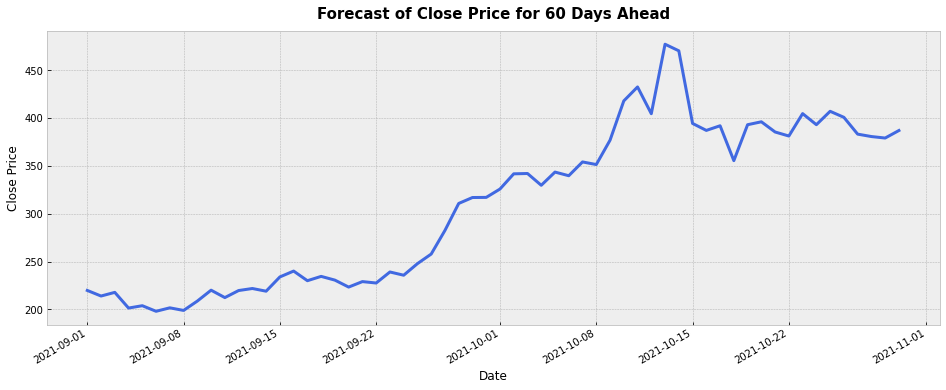

In [46]:
#visualize forecast prediction from close price
plt.figure(figsize = (16,6))
df_result['Forecast'].plot(color = 'royalblue', linewidth = 3)
plt.title('Forecast of Close Price for 60 Days Ahead', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price', fontsize = 12)
plt.show()

## Extreme Gradient Boosting Regressor

In [47]:
#use grid search cv for searching best hyperparameter
gbm = XGBRegressor()
reg_cv = GridSearchCV(gbm, {'colsample_bytree' : [1.0], 'min_child_weight' : [1.0,1.2], 'max_depth' : [3,4,6], 
                            'n_estimators': [50,100]}, verbose = 1)
reg_cv.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [48]:
#check best parameter
reg_cv.best_params_

{'colsample_bytree': 1.0,
 'max_depth': 4,
 'min_child_weight': 1.0,
 'n_estimators': 100}

In [49]:
#build model
xgb = XGBRegressor(**reg_cv.best_params_)
%time xgb.fit(X_train, y_train)
print('Training Accuracy Score : {}'.format(xgb.score(X_train, y_train)))
print('Testing Accuracy Score : {}'.format(xgb.score(X_test, y_test)))

Wall time: 98.7 ms
Training Accuracy Score : 0.9999784425639873
Testing Accuracy Score : 0.997202890693338


In [50]:
#prediction
y_pred = xgb.predict(X_test)
print(y_pred)

[ 16.992876   33.255875   63.16563    69.98771   147.34341    50.227924
  48.7038    144.73825    27.648144   16.757887  393.9972     29.916042
  48.556973  155.75114    48.818428   65.39952    20.679796   29.448917
 113.699196  133.04005    65.63881    27.856955  196.90317    20.030308
 212.71675    67.38688   233.26617    80.45007   165.02733   152.9786
 132.67137    16.992876  181.61914   175.6833    132.09445    50.332764
 114.2335     67.84892   181.29893    69.49713    16.568583   19.445469
 352.06915    70.36194    47.764465   14.4046955 170.35281    66.21718
 233.0537     69.77871   165.72903   152.62476   124.366615   48.331684
  66.16127    22.730284  375.93668   132.77324   132.69011   112.56454
  56.71653    68.42116   153.50856   155.74536   389.8228     82.14975
  69.3228     20.882782  315.26813   113.699196  158.29935    19.521286
 234.90417    56.547043   71.619644   64.61202   165.07166    19.43451
 132.213      18.287075  239.3569     20.882782  165.15147    14.40469

In [51]:
#check MAE, MSE, RMSE & R2 score
mae = metrics.mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error : {}'.format(mae * 0.1))
mse = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error : {}'.format(mse * 0.01))
rmse = math.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error : {}'.format(rmse * 0.1))
r2_score = metrics.r2_score(y_test, y_pred).round(2)
print('R2 Score : {}'.format(r2_score))

Mean Absolute Error : 0.26814520226584543
Mean Squared Error : 0.2437770626772145
Root Mean Squared Error : 0.49373784813118643
R2 Score : 1.0


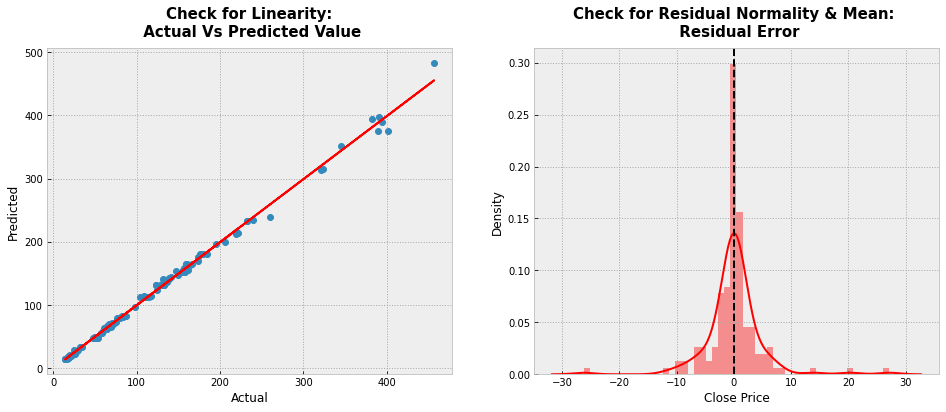

In [52]:
f = plt.figure(figsize = (16,6))

#check for linearity
ax = f.add_subplot(121)
plt.plot(y_test, y_pred, 'o')
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, color = 'r')
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
ax.set_title('Check for Linearity:\n Actual Vs Predicted Value', fontsize = 15, pad = 12, fontweight = 'bold')
ax.set_xlabel('Actual', fontsize = 12)
ax.set_ylabel('Predicted', fontsize = 12)

#check for residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred), ax = ax, color = 'r')
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
ax.axvline((y_test - y_pred).mean(), color = 'k', linestyle = '--')
ax.set_title('Check for Residual Normality & Mean: \n Residual Error', fontsize = 15, pad = 12, fontweight = 'bold')
ax.set_xlabel('Close Price', fontsize = 12)
ax.set_ylabel('Density', fontsize = 12)
plt.show()

In [53]:
#prediction of extreme gradient boosting regressor for forecast 60 days ahead
num = 60
X_Predict = X[-num:]
Forecast = xgb.predict(X_Predict)
print(Forecast)

[216.99217 216.23305 215.84471 208.05084 201.54979 197.71777 201.77924
 199.16393 208.75566 214.7252  212.234   220.10567 220.83704 222.6999
 234.35022 234.95816 235.16211 234.54066 233.54723 221.91612 233.0537
 233.26617 234.90417 235.19218 245.80916 239.3569  286.3501  313.71725
 307.62897 313.4756  315.26813 348.5975  336.5587  328.32953 349.66675
 352.06915 353.4962  346.3837  386.04218 418.9867  416.22617 413.7234
 484.33627 483.0022  385.27197 397.73166 389.8748  373.66315 374.68533
 399.26035 375.70322 382.26404 410.96683 389.8228  397.83624 400.31454
 393.9972  371.15863 377.13605 375.93668]


In [54]:
#check last date for forecasting
date = np.array(df_moderna.index) 
last_date = date[len(date) - 1]
print(last_date)

2021-09-01T00:00:00.000000000


In [55]:
#create timeseries from the last date
time = pd.date_range('2021-09-01', periods = num, freq = 'd')
print(time)

DatetimeIndex(['2021-09-01', '2021-09-02', '2021-09-03', '2021-09-04',
               '2021-09-05', '2021-09-06', '2021-09-07', '2021-09-08',
               '2021-09-09', '2021-09-10', '2021-09-11', '2021-09-12',
               '2021-09-13', '2021-09-14', '2021-09-15', '2021-09-16',
               '2021-09-17', '2021-09-18', '2021-09-19', '2021-09-20',
               '2021-09-21', '2021-09-22', '2021-09-23', '2021-09-24',
               '2021-09-25', '2021-09-26', '2021-09-27', '2021-09-28',
               '2021-09-29', '2021-09-30', '2021-10-01', '2021-10-02',
               '2021-10-03', '2021-10-04', '2021-10-05', '2021-10-06',
               '2021-10-07', '2021-10-08', '2021-10-09', '2021-10-10',
               '2021-10-11', '2021-10-12', '2021-10-13', '2021-10-14',
               '2021-10-15', '2021-10-16', '2021-10-17', '2021-10-18',
               '2021-10-19', '2021-10-20', '2021-10-21', '2021-10-22',
               '2021-10-23', '2021-10-24', '2021-10-25', '2021-10-26',
      

In [56]:
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']
df_predict.head()

,Forecast
2021-09-01,216.992172
2021-09-02,216.233047
2021-09-03,215.844711
2021-09-04,208.050842
2021-09-05,201.549789


In [57]:
#joining dataframe moderna & prediction result
df_result = pd.concat([df_moderna, df_predict], axis = 1)
df_result.tail(num)

,High,Low,Open,Close,Volume,MA for 20 days,MA for 50 days,Forecast
2021-09-01,394.980011,375.200012,382.837006,389.940002,11617300.0,399.7655,329.535099,216.992172
2021-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216.233047
2021-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215.844711
2021-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.050842
2021-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201.549789
2021-09-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197.717773
2021-09-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201.779236
2021-09-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,199.163925
2021-09-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.755661
2021-09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214.725204


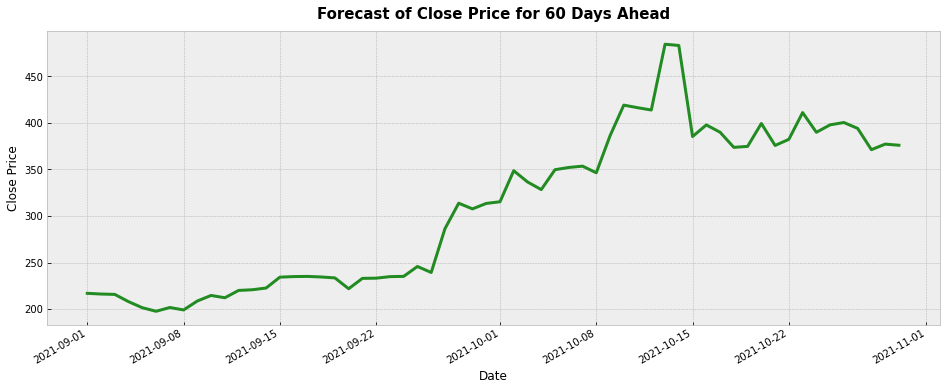

In [58]:
#visualize forecast prediction from close price
plt.figure(figsize = (16,6))
df_result['Forecast'].plot(color = 'forestgreen', linewidth = 3)
plt.title('Forecast of Close Price for 60 Days Ahead', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price', fontsize = 12)
plt.show()

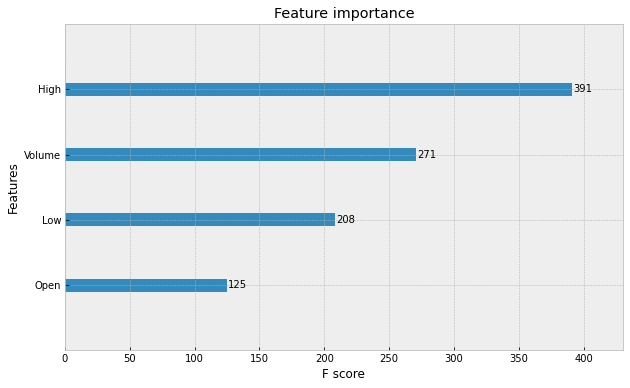

In [59]:
#visualize feature importance from model
fig, ax = plt.subplots(figsize = (10,6))
plot_importance(xgb, ax = ax)
plt.show()